In [1]:
import torch, pickle, argparse, os, warnings, copy, time, mlflow
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep
from models import ConvNet, CConvNet
from data_loader import load_test_data, load_train_data
from foolbox import PyTorchModel
from foolbox.attacks import NewtonFoolAttack
from tqdm.notebook import tqdm
from attack_helper import batched_predictions, batched_predictions, batched_logits
from mlflow.tracking.artifact_utils import get_artifact_uri
import matplotlib.pyplot as plt

In [2]:
run_name = 1697206030
tracking_uri = 'sqlite:///mlruns/database.db'
mlflow.set_tracking_uri(tracking_uri)
df=mlflow.search_runs(experiment_names=['model_training'])
run_id=df[df['tags.mlflow.runName']==str(run_name)]['run_id'].values[0]
artifact_path = get_artifact_uri(run_id=run_id, tracking_uri=tracking_uri)
dirs=os.listdir(artifact_path)

for s in dirs:
    if s.find('.ckpt') >= 0:
        checkpoint = s
        break

checkpoint_path = os.path.join(artifact_path, checkpoint)

best_model = torch.load(checkpoint_path)
hparams = argparse.Namespace(**best_model['hyper_parameters'])
if df[df['tags.mlflow.runName']==str(run_name)]['tags.model'].values[0] == 'ConvNet':
    model = ConvNet(hparams, None, None).eval()
elif df[df['tags.mlflow.runName']==str(run_name)]['tags.model'].values[0] == 'CConvNet':
    model = CConvNet(hparams, None, None).eval()
else:
    raise NotImplementedError(f"Model has to be 'ConvNet' or 'CConvNet'. Got {df[df['tags.mlflow.runName']==str(run_name)]['tags.model'].values[0]}.")
model.load_state_dict(best_model['state_dict'])

test_rot = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.test_rot'].values[0])

if df[df['tags.mlflow.runName']==str(run_name)]['params.flat'].values[0] is None:
    flat = False
else:
    flat = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.flat'].values[0])

if flat:
    padded_img_size = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.padded_img_size'].values[0])

    if test_rot:
        TEST_PATH = "flat_mnist_test_aug_" + str(padded_img_size[0]) + "x" + str(padded_img_size[1]) + ".gz"
    else:
        TEST_PATH = "flat_mnist_test_" + str(padded_img_size[0]) + "x" + str(padded_img_size[1]) + ".gz"

    test_data = load_train_data(TEST_PATH)

else:    
    if test_rot:
        TEST_PATH = "s2_mnist_cs1.gz"
        test_data = load_test_data(TEST_PATH)
    else:
        TEST_PATH = "s2_mnist_test_sphere_center.gz"
        test_data = load_train_data(TEST_PATH)

In [5]:
# total = 10000
bs = 100
total = 100

images = test_data[:total][0]
labels = test_data[:total][1]

fmodel = PyTorchModel(model, bounds=(0, 255))

In [6]:
clean_pred = batched_predictions(model, images, bs)

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
attack = NewtonFoolAttack(steps=100, stepsize=30/255)

In [8]:
raw_advs, clipped_advs, success = attack(fmodel, images.cuda(), clean_pred[:100].cuda(), epsilons=0.)
print(success)

tensor([ True,  True,  True, False,  True,  True, False,  True,  True,  True,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
         True, False, False,  True,  True, False,  True,  True, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
        False, False,  True,  True, False, False,  True,  True,  True,  True,
         True, False,  True, False,  True, False, False,  True, False, False,
         True, False,  True, False,  True,  True, False,  True,  True,  True,
         True, False,  True,  True, False,  True,  True, False, False,  True,
         True, False, False, False,  True, False,  True,  True, False,  True],
       device='cuda:0')


In [9]:
raw_advs

tensor([[[[ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          ...,
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan]]],


        [[[ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          ...,
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan]]],


        [[[ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          ...,
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          [ nan,  nan,  nan,  ...,  nan,  nan,  nan],
          [ nan,  nan,  nan, 

In [72]:
clipped_advs[10:15]

tensor([[[[   nan,    nan,    nan,  ...,    nan,    nan,    nan],
          [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
          [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
          ...,
          [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
          [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
          [   nan,    nan,    nan,  ...,    nan,    nan,    nan]]],


        [[[0.0054, 0.0054, 0.0054,  ..., 0.0054, 0.0054, 0.0000],
          [0.0054, 0.0054, 0.0000,  ..., 0.0054, 0.0054, 0.0000],
          [0.0054, 0.0000, 0.0000,  ..., 0.0054, 0.0054, 0.0000],
          ...,
          [0.0000, 0.0054, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0054, 0.0054, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0050],
          [0.0050, 0.0050, 0.0050,  ..., 0.0050, 0.0050, 0.0050],
          [0.0050, 0.0050, 0.0050,  ..

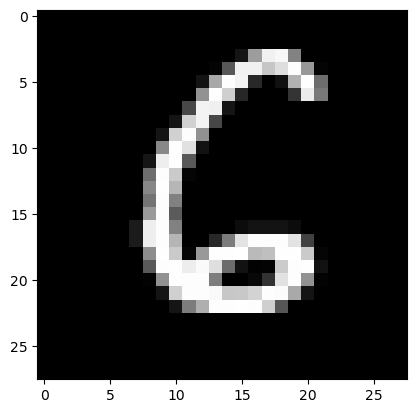

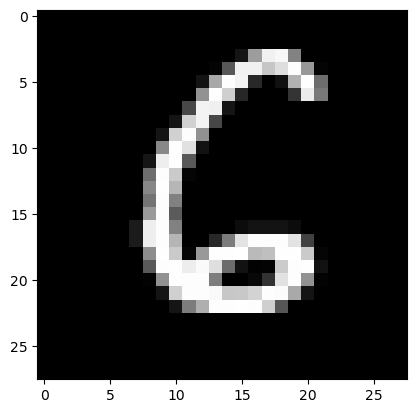

In [10]:
plt.imshow(clipped_advs[-2,0].cpu(), cmap='gray')
plt.show()
plt.imshow(images[-2,0], cmap='gray')
plt.show()

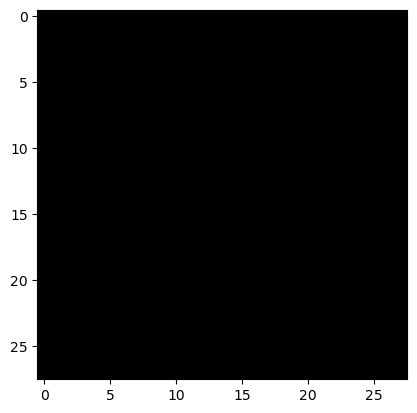

In [11]:
plt.imshow(clipped_advs[-2,0].cpu() - images[-2,0], cmap='gray')
plt.show()

In [12]:
success[-2].item()

False